## 1.0 EDA: Learning Equality - Content to Topic

### Install and Load libs

 📦 Install the 'stopwordsiso' package, which provides stopwords for multiple languages.
Useful for text preprocessing in NLP tasks.

In [1]:
!pip install stopwordsiso

In [2]:
#### 📊 Data Analysis Libraries ####
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns

#### ☁️ Word Cloud Visualization ####
from wordcloud import WordCloud

#### 🔁 Progress Bars ####
from tqdm.notebook import tqdm

#### 💬 NLP & Embedding Models ####
from sentence_transformers import SentenceTransformer

#### 🔍 Dimensionality Reduction ####
from sklearn.manifold import TSNE

#### 📈 Plotting & Visualization Settings ####
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (6, 4)
plt.rc('font', weight='bold')

#### 🧠 Text Vectorization ####
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### 🛑 Stopwords Handling ####
import stopwordsiso as stopwords

#### 🧹 Regex and Warnings ####
import re
import warnings
warnings.filterwarnings("ignore")


#### Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
content = pd.read_csv("/content/drive/MyDrive/learning-equality-curriculum-recommendations (2)/content.csv")
topics  = pd.read_csv("/content/drive/MyDrive/learning-equality-curriculum-recommendations (2)/topics.csv")
correlations = pd.read_csv("/content/drive/MyDrive/learning-equality-curriculum-recommendations (2)/correlations.csv")

In [5]:
content.head(3)

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN


In [6]:
topics.head(3)

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True


In [7]:
correlations.head(3)

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99


### Topics - Analysis

#### Nan Values

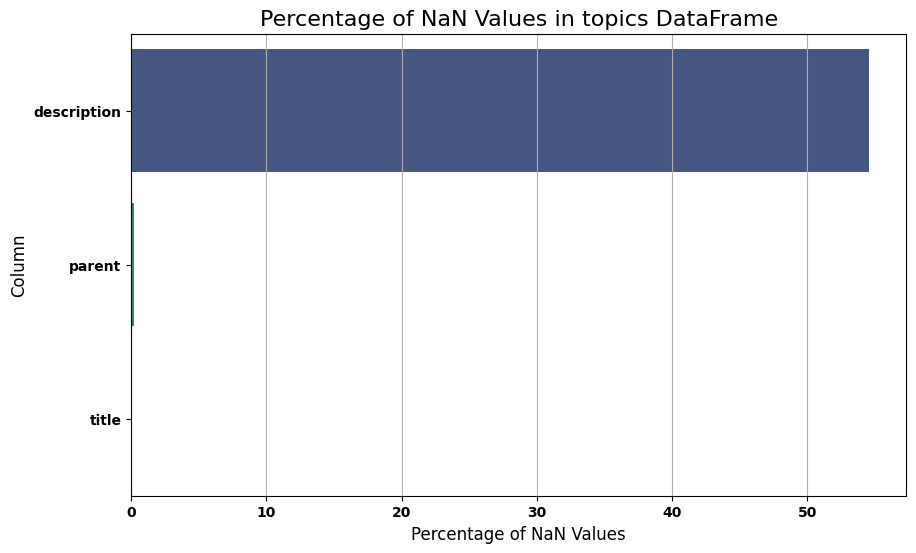

In [8]:
# Calculate the percentage of missing values for each column in the topics DataFrame
nan_percentages = topics.isnull().sum() / len(topics) * 100

# Create a DataFrame from the calculated percentages
nan_df = nan_percentages.reset_index()
nan_df.columns = ['Column', 'NaN Percentage']

# Filter out columns with 0% NaN values for better visualization
nan_df = nan_df[nan_df['NaN Percentage'] > 0].sort_values(by='NaN Percentage', ascending=False)

# Plot the percentage of NaN values
plt.figure(figsize=(10, 6))
sns.barplot(x='NaN Percentage', y='Column', data=nan_df, palette='viridis')
plt.title('Percentage of NaN Values in topics DataFrame', fontsize=16)
plt.xlabel('Percentage of NaN Values', fontsize=12)
plt.ylabel('Column', fontsize=12)
plt.grid(axis='x')
plt.show()

#### Title & Description

#### Language

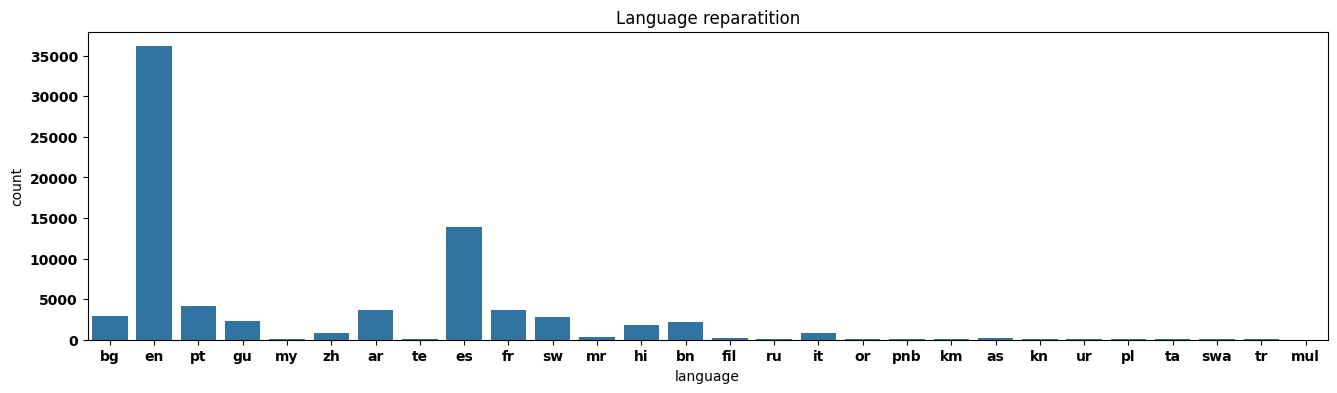

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
sns.countplot(x="language", data=topics)
plt.title('Language reparatition')
plt.show()

In [10]:
# @title title description length - histogram_with_median
def plot_histogram_with_median(data, title, xlabel, ylabel, ax, bins=np.arange(0, 141, 5), color='#2ab0ff'):
    """
    Generates and displays a histogram with a median line on a given axes.

    Args:
        data (pd.Series or np.ndarray): Data to plot the histogram from.
        title (str): Title of the histogram.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        ax (matplotlib.axes.Axes): The axes to plot on.
        bins (array_like): Bins for the histogram.
        color (str): Face color of the histogram bars.
    """
    ax.hist(data,
            bins=bins,
            facecolor=color,
            edgecolor='#e0e0e0',
            linewidth=0.5,
            alpha=0.7)

    median_len = np.median(data)
    ax.axvline(median_len, color='red', linestyle='dashed', linewidth=1)
    ax.text(median_len*1.1, ax.get_ylim()[1]*0.9, f'Median: {median_len:.2f}', color='red')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)


def plot_topic_text_histograms(topics_df):
    """
    Generates and displays histograms for topic title length, description length,
    and combined title and description length. Plots title and description
    histograms on the same line.

    Args:
        topics_df (pd.DataFrame): DataFrame containing topic data with 'title' and 'description' columns.
    """
    sns.set_style("whitegrid") # Use a whitegrid style for better readability

    # Plot histograms for title and description lengths on the same line
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Plot histogram for title length
    title_len = np.clip(topics_df['title'].fillna('').apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(title_len,
                               'Distribution of Word Count in Topic Titles',
                               'Number of Words',
                               'Frequency',
                               ax=axes[0])

    # Plot histogram for description length
    description_len = np.clip(topics_df['description'].fillna('').apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(description_len,
                               'Distribution of Word Count in Topic Descriptions',
                               'Number of Words',
                               'Frequency',
                               ax=axes[1])

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 1, figsize=(16, 4))
    # Plot histogram for combined title and description length
    texts = topics_df['title'].fillna('') + ' ' + topics_df['description'].fillna('')
    title_desc_len = np.clip(texts.apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(title_desc_len,
                               'Distribution of Word Count in Topic Titles and Descriptions (Combined)',
                               'Number of Words',
                               'Frequency',
                               ax=plt.gca()) # Use gca() to get the current axes for the single plot
    plt.show()

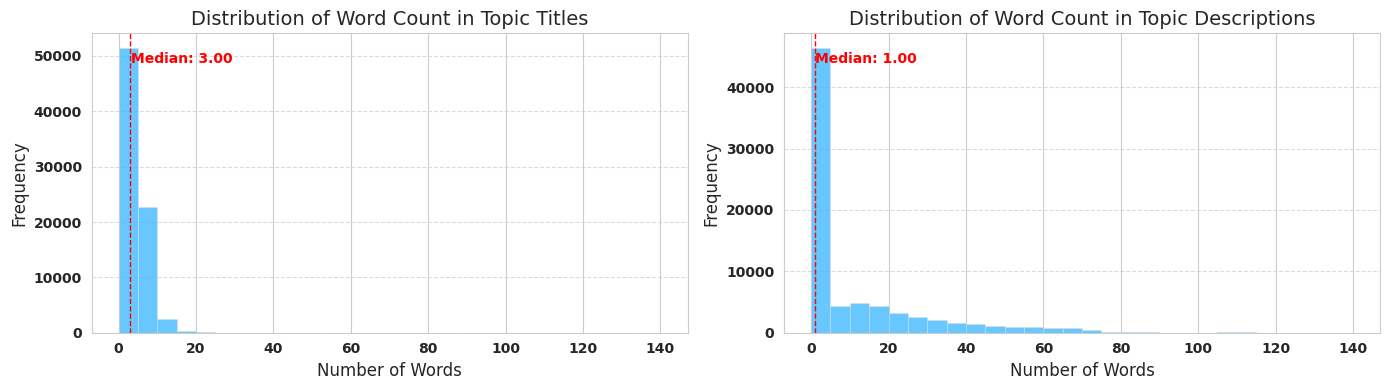

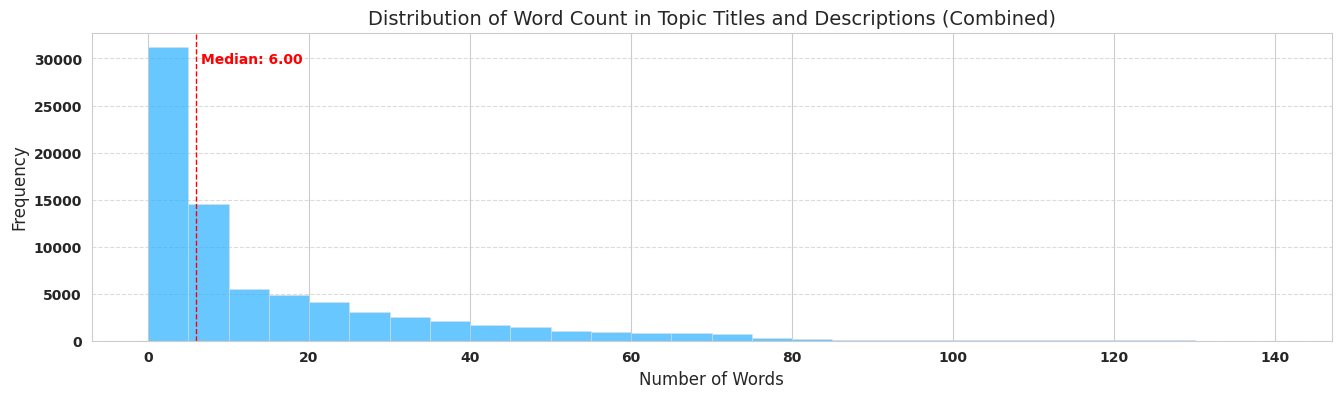

In [11]:
plot_topic_text_histograms(topics)

* 📊 **Word Count Distribution**:

  * **Topic Titles**: Median word count is **3**, with most titles being short (≤5 words).
  * **Topic Descriptions**: Median word count is **1**, but shows a long tail with some descriptions exceeding **100 words**.
  * Both distributions are highly **right-skewed**, indicating sparse usage of long texts.


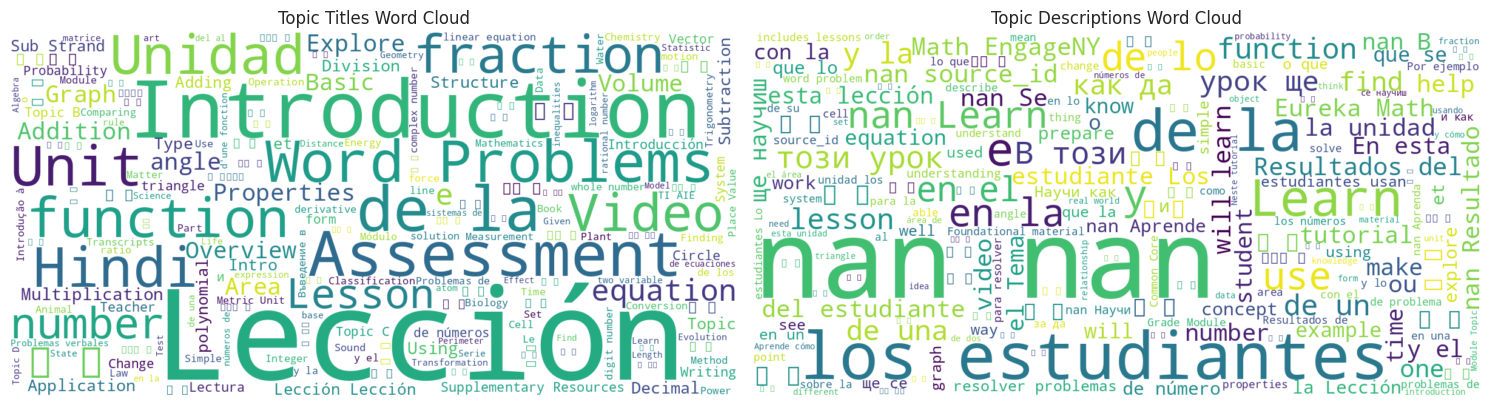

In [12]:
text_title = " ".join(title for title in topics.title.astype(str))
word_cloud_title = WordCloud(collocations = True, background_color = 'white', width = 1200, height = 600).generate(text_title)


text_description = " ".join(description for description in topics.description.astype(str))
word_cloud_description = WordCloud(collocations = True, background_color = 'white', width = 1200, height = 600).generate(text_description)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(word_cloud_title, interpolation='bilinear')
axes[0].set_title('Topic Titles Word Cloud')
axes[0].axis("off")

axes[1].imshow(word_cloud_description, interpolation='bilinear')
axes[1].set_title('Topic Descriptions Word Cloud')
axes[1].axis("off")

plt.tight_layout()
plt.show()

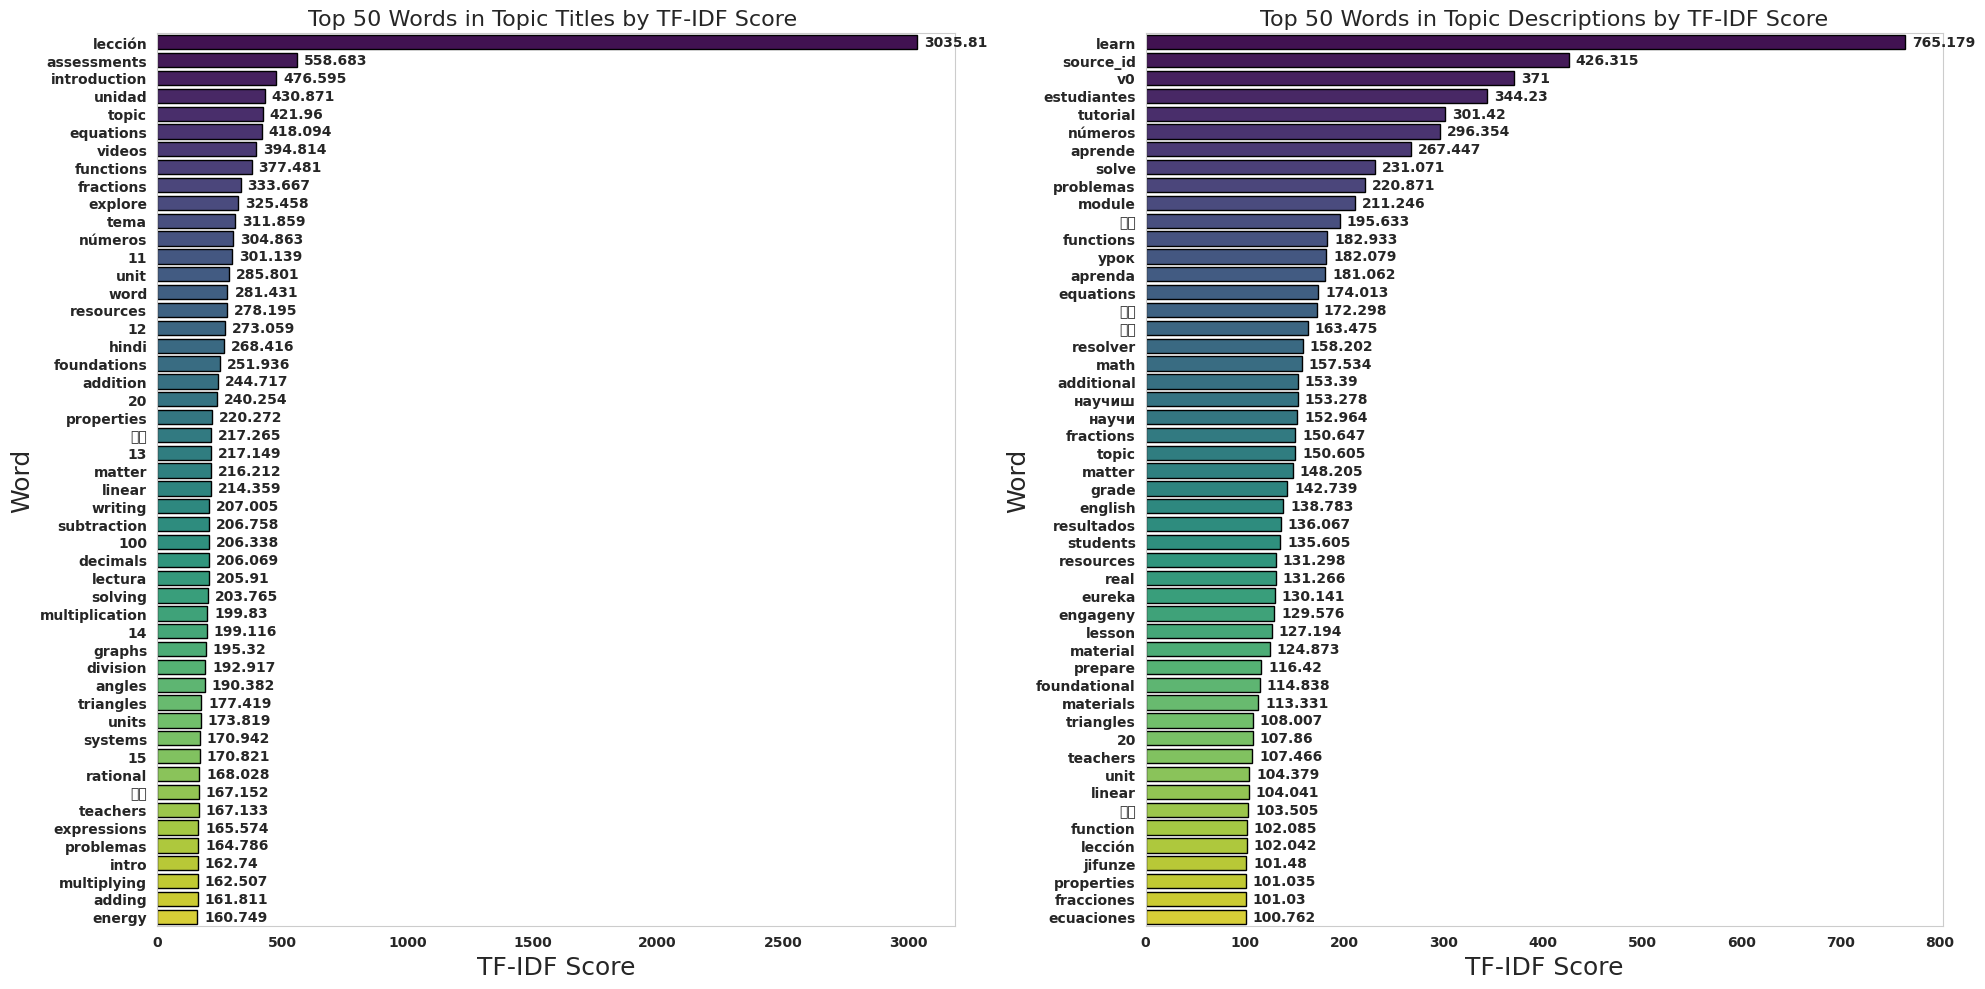

In [13]:
# @title  TF-IDF Score Top 50
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import stopwordsiso as stopwords
import re

# Get the unique languages from the topics DataFrame
languages = topics['language'].unique().tolist()

# Combine stop words from the languages present in the topics DataFrame
combined_stops = set()
for lang in languages:
    try:
        combined_stops.update(stopwords.stopwords(lang))
    except:
        print(f"Could not load stop words for language code: {lang}. Skipping.")


def plot_top_tfidf_words(df, text_column, title, ax, stop_words):
    """
    Generates and displays a bar plot of the top 50 TF-IDF words for a given text column.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str): The name of the column containing the text data.
        title (str): Title for the plot.
        ax (matplotlib.axes.Axes): The axes to plot on.
        stop_words (set): A set of stop words to use.
    """
    # Fill NaN values and convert to string
    text_data = df[text_column].fillna('').astype(str)

    # Remove numbers from the text data
    #text_data = text_data.apply(lambda x: re.sub(r'\d+', '', x))

    # Create TF-IDF vectorizer with custom stop words
    tfidf = TfidfVectorizer(stop_words=list(stop_words))

    # Fit and transform the text data
    tfidf_matrix = tfidf.fit_transform(text_data)

    # Get feature names (words)
    feature_names = tfidf.get_feature_names_out()

    # Calculate the sum of TF-IDF scores for each word
    tfidf_sums = np.sum(tfidf_matrix.toarray(), axis=0)

    # Create a pandas Series of words and their total TF-IDF scores
    word_tfidf_scores = pd.Series(tfidf_sums, index=feature_names)

    # Get the top 50 words by TF-IDF score
    top_words = word_tfidf_scores.sort_values(ascending=False).head(50)

    # Create a DataFrame for plotting
    top_words_df = top_words.reset_index()
    top_words_df.columns = ['word', 'tfidf_score']

    # Plot the top 50 words using a bar plot
    sns.barplot(x='tfidf_score', y='word', data=top_words_df, edgecolor="#000000", palette='viridis', ax=ax)

    # Add labels to the bars
    for container in ax.containers:
        ax.bar_label(container, padding=5)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("TF-IDF Score", fontsize=18)
    ax.set_ylabel("Word", fontsize=18)
    ax.grid(axis='x')

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Topic Titles
plot_top_tfidf_words(topics, 'title', "Top 50 Words in Topic Titles by TF-IDF Score ", axes[0], combined_stops)

# Plot for Topic Descriptions
plot_top_tfidf_words(topics, 'description', "Top 50 Words in Topic Descriptions by TF-IDF Score", axes[1], combined_stops)

plt.tight_layout()
plt.show()

Now let’s apply Zipf’s Law — this helps identify the most frequent words that carry most of the information. We select the top k terms covering 90% of total word usage. This keeps the TF-IDF matrix compact, efficient, and focused on high-signal vocabulary.

In [14]:

# Step 1: Create combined text field
texts = topics['title'].fillna('') + ' ' + topics['description'].fillna('')
texts = texts.tolist()

# Step 2: Fit CountVectorizer to get vocabulary and raw frequencies
count_vectorizer = CountVectorizer(stop_words=list(combined_stops))
X_counts = count_vectorizer.fit_transform(texts)
word_freq = X_counts.sum(axis=0).A1  # get total frequency per word
vocab = count_vectorizer.get_feature_names_out()

# Step 3: Sort words by frequency (Zipf’s Law approximation)
freq_df = pd.DataFrame({'word': vocab, 'freq': word_freq})
freq_df = freq_df.sort_values(by='freq', ascending=False).reset_index(drop=True)

# Step 4: Compute total frequency and cumulative frequency
freq_df['cum_freq'] = freq_df['freq'].cumsum()
total_freq = freq_df['freq'].sum()

# Step 5: Zipf-based cutoff for 90% of total frequency
alpha = 0.90
threshold = alpha * total_freq

# Step 6: Find how many top words reach that threshold
k = (freq_df['cum_freq'] < threshold).sum()
print(f"🔢 Zipf-based max_features (alpha={alpha}): {k}")

# Step 7: Use it in TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=k)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)


🔢 Zipf-based max_features (alpha=0.9): 18953


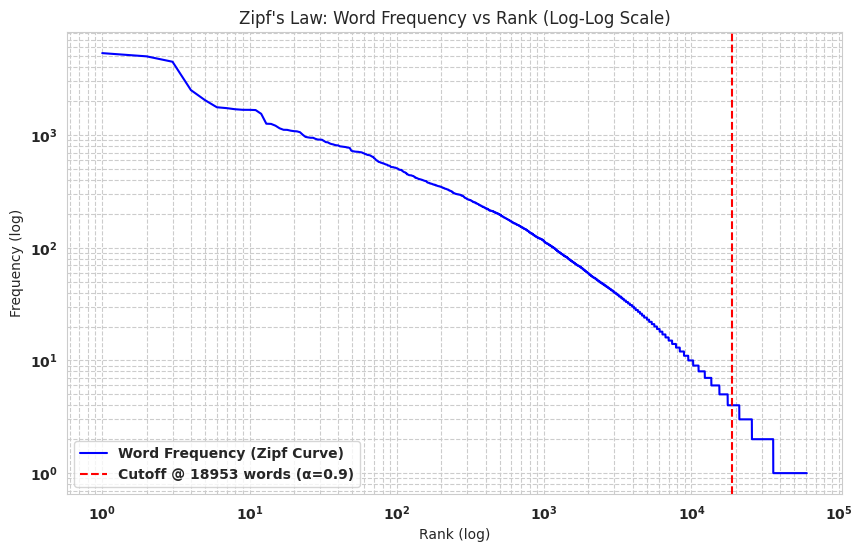

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.loglog(freq_df.index + 1, freq_df['freq'], label='Word Frequency (Zipf Curve)', color='blue')
plt.axvline(x=18953, color='red', linestyle='--', label=f'Cutoff @ {18953} words (α=0.9)')
plt.title("Zipf's Law: Word Frequency vs Rank (Log-Log Scale)")
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


This Zipf plot shows that a small number of words appear very frequently, while most occur rarely. The red line marks the top 18,953 words, which together cover 90% of total word usage. This justifies limiting the TF-IDF vocabulary to reduce noise and improve model efficiency.

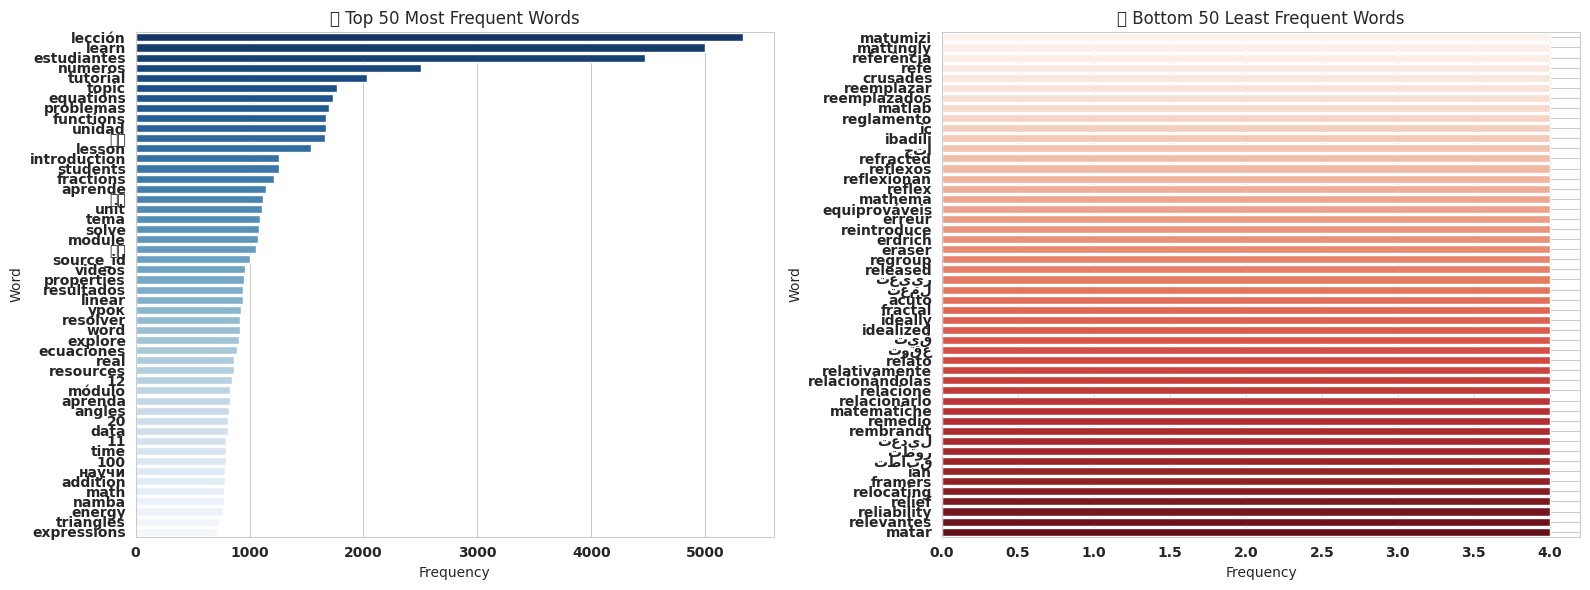

In [16]:

# Take only the selected Zipf-based vocabulary
zipf_vocab = zipf_vocab = freq_df.iloc[:k]

# Top 50 words from selected vocab
top_50 = zipf_vocab.head(50)

# Bottom 50 words from selected vocab
bottom_50 = zipf_vocab.tail(50)


fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Create a figure with 2 subplots side by side

# Plot for Top 50 Most Frequent Words
sns.barplot(x='freq', y='word', data=top_50, palette='Blues_r', ax=axes[0])
plt.grid()
axes[0].set_title("🔝 Top 50 Most Frequent Words")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Word")

# Plot for Bottom 50 Least Frequent Words
sns.barplot(x='freq', y='word', data=bottom_50, palette='Reds', ax=axes[1])
axes[1].set_title("🔻 Bottom 50 Least Frequent Words")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Word")

plt.tight_layout() # Adjust layout to prevent overlapping
plt.grid()
plt.show()

#### Category

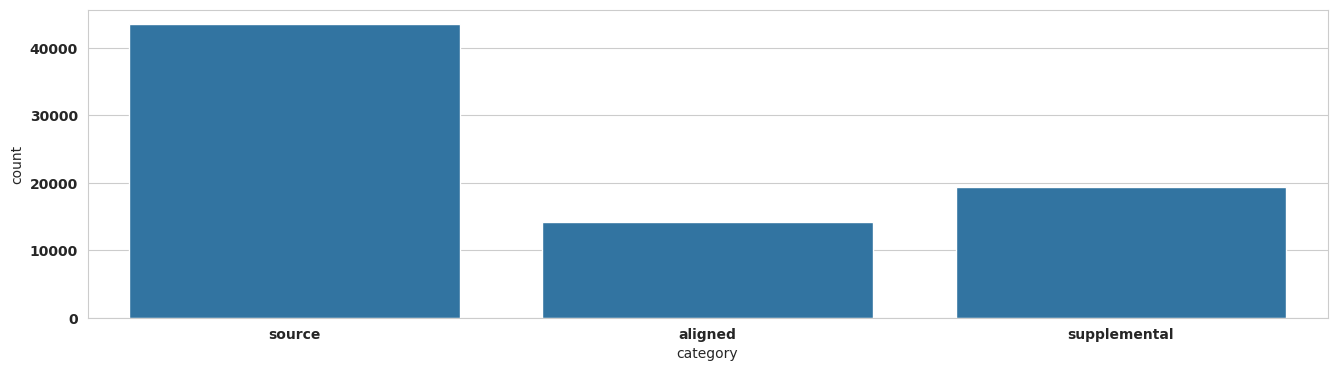

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
sns.countplot(x='category', data=topics)
plt.show()


#### Level & Content

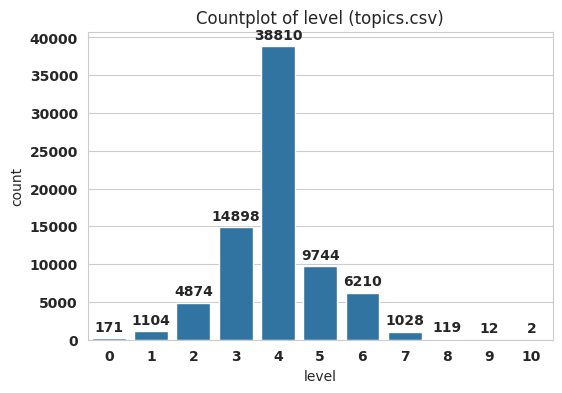

In [18]:
ax = sns.countplot(x = topics["level"])

for container in ax.containers:
        ax.bar_label(container, padding = 3)
plt.title("Countplot of level (topics.csv)")
plt.show()

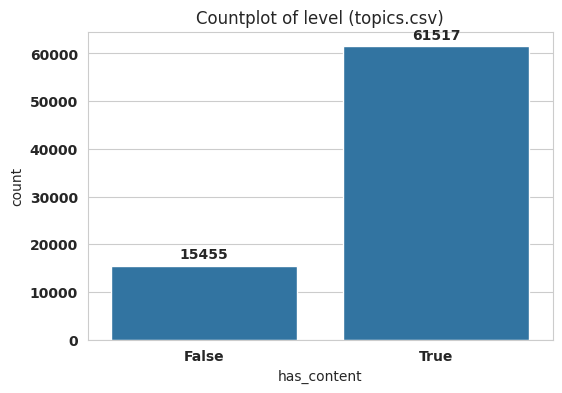

In [19]:
ax = sns.countplot(x = topics["has_content"])

for container in ax.containers:
        ax.bar_label(container, padding = 3)
plt.title("Countplot of level (topics.csv)")
plt.show()

### Content - Analysis

#### Nan Values

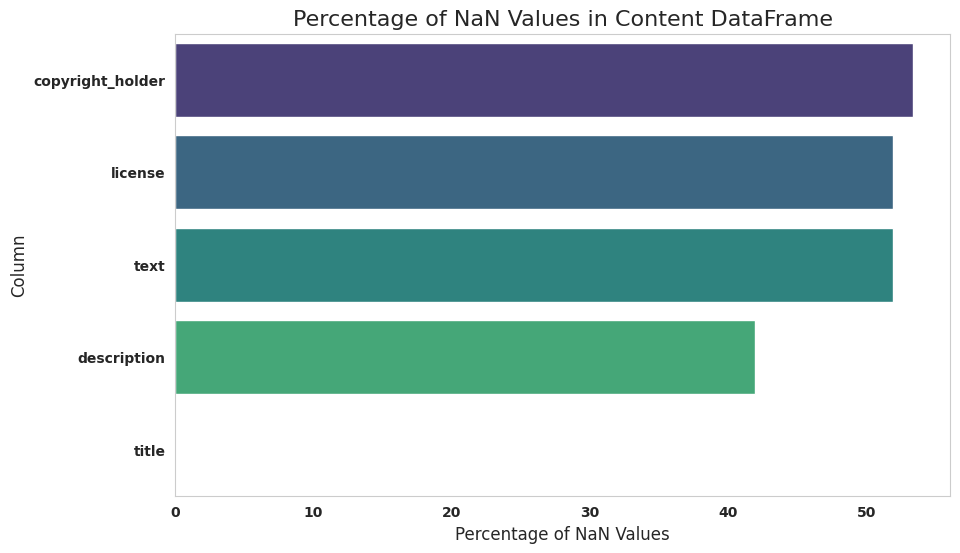

In [20]:
# Calculate the percentage of missing values for each column in the content DataFrame
nan_percentages = content.isnull().sum() / len(content) * 100

# Create a DataFrame from the calculated percentages
nan_df = nan_percentages.reset_index()
nan_df.columns = ['Column', 'NaN Percentage']

# Filter out columns with 0% NaN values for better visualization
nan_df = nan_df[nan_df['NaN Percentage'] > 0].sort_values(by='NaN Percentage', ascending=False)

# Plot the percentage of NaN values
plt.figure(figsize=(10, 6))
sns.barplot(x='NaN Percentage', y='Column', data=nan_df, palette='viridis')
plt.title('Percentage of NaN Values in Content DataFrame', fontsize=16)
plt.xlabel('Percentage of NaN Values', fontsize=12)
plt.ylabel('Column', fontsize=12)
plt.grid(axis='x')
plt.show()

#### Title and Content

In [21]:
# @title Title Text Description length- histogram_with_median
def plot_histogram_with_median(data, title, xlabel, ylabel, ax, bins=np.arange(0, 141, 5), color='#2ab0ff'):
    """
    Generates and displays a histogram with a median line on a given axes.

    Args:
        data (pd.Series or np.ndarray): Data to plot the histogram from.
        title (str): Title of the histogram.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        ax (matplotlib.axes.Axes): The axes to plot on.
        bins (array_like): Bins for the histogram.
        color (str): Face color of the histogram bars.
    """
    ax.hist(data,
            bins=bins,
            facecolor=color,
            edgecolor='#e0e0e0',
            linewidth=0.5,
            alpha=0.7)

    median_len = np.median(data)
    ax.axvline(median_len, color='red', linestyle='dashed', linewidth=1)
    ax.text(median_len*1.1, ax.get_ylim()[1]*0.9, f'Median: {median_len:.2f}', color='red')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)


def plot_topic_text_histograms(content_df):
    """
    Generates and displays histograms for Content title length, description length,
    and combined title and description length. Plots title and description
    histograms on the same line.

    Args:
        content_df (pd.DataFrame): DataFrame containing Content data with 'title' and 'description' columns.
    """
    sns.set_style("whitegrid") # Use a whitegrid style for better readability

    # Plot histograms for title and description lengths on the same line
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Plot histogram for title length
    title_len = np.clip(content_df['title'].fillna('').apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(title_len,
                               'Dist Word Count in Content Titles',
                               'Number of Words',
                               'Frequency',
                               ax=axes[0])

    # Plot histogram for description length
    description_len = np.clip(content_df['description'].fillna('').apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(description_len,
                               'Dist Word Count in Content Descriptions',
                               'Number of Words',
                               'Frequency',
                               ax=axes[1])

    description_len = np.clip(content_df['text'].fillna('').apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(description_len,
                               'Dist Word Count in Content Text',
                               'Number of Words',
                               'Frequency',
                               ax=axes[2])

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 1, figsize=(16, 4))
    # Plot histogram for combined title and description length
    texts = content_df['title'].fillna('') + ' ' + content_df['description'].fillna('')+content_df['text'].fillna('')
    title_desc_len = np.clip(texts.apply(lambda x: len(x.strip().split(' '))), 0, 10**9)
    plot_histogram_with_median(title_desc_len,
                               'Dist Word Count in Content Titles,Descriptions, Text (Combined)',
                               'Number of Words',
                               'Frequency',
                               ax=plt.gca()) # Use gca() to get the current axes for the single plot
    plt.show()

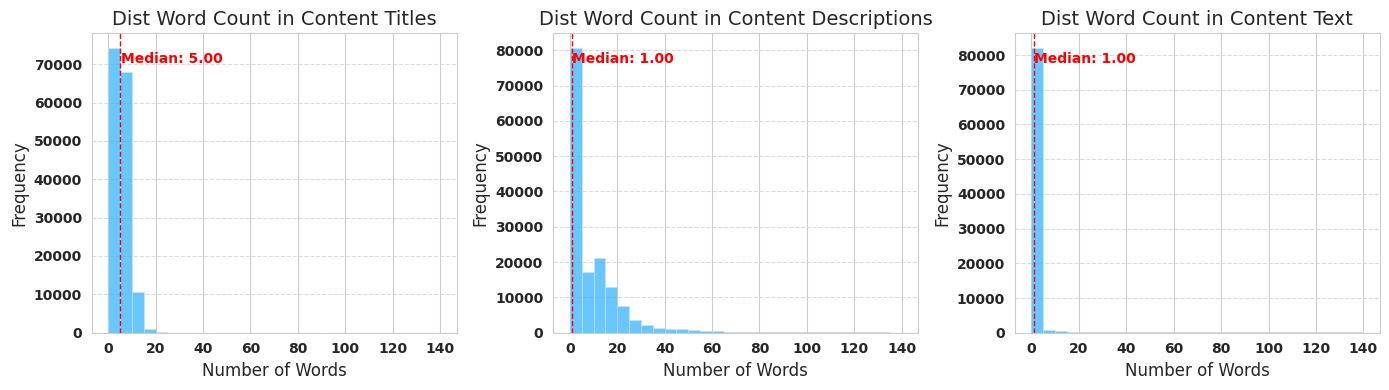

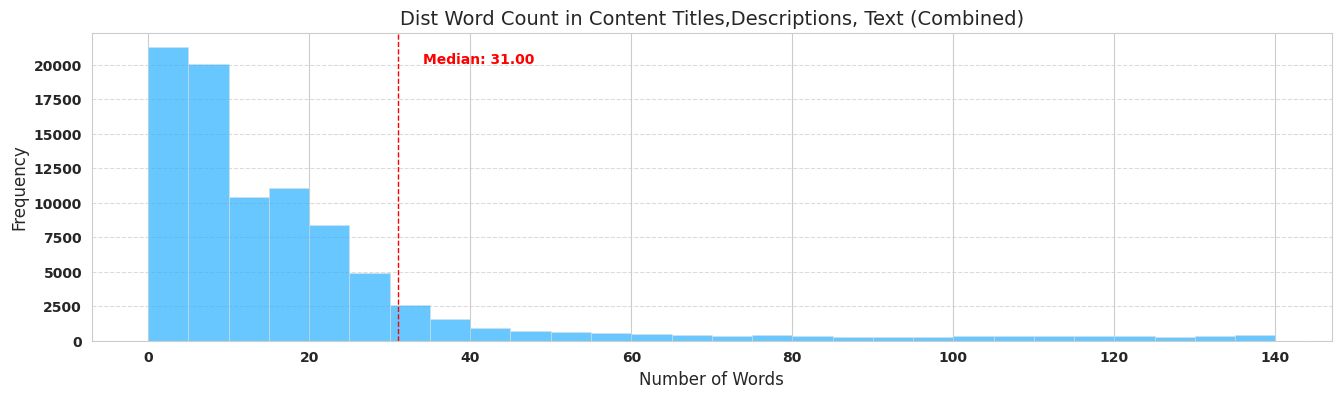

In [22]:
plot_topic_text_histograms(content)

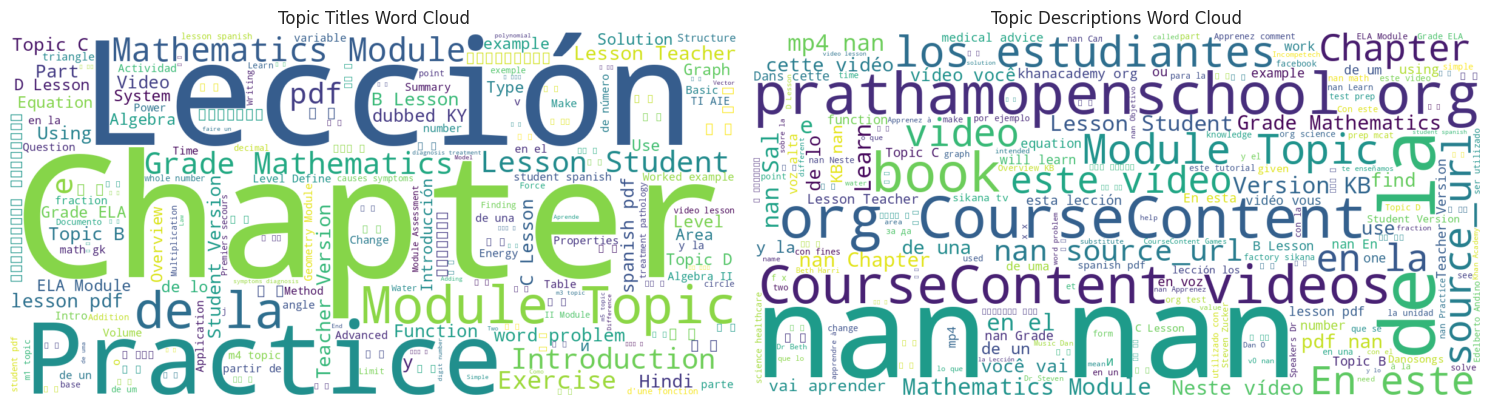

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_title = " ".join(title for title in content.title.astype(str))
word_cloud_title = WordCloud(collocations = True, background_color = 'white', width = 1200, height = 600).generate(text_title)


text_description = " ".join(description for description in content.description.astype(str))
word_cloud_description = WordCloud(collocations = True, background_color = 'white', width = 1200, height = 600).generate(text_description)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(word_cloud_title, interpolation='bilinear')
axes[0].set_title('Topic Titles Word Cloud')
axes[0].axis("off")

axes[1].imshow(word_cloud_description, interpolation='bilinear')
axes[1].set_title('Topic Descriptions Word Cloud')
axes[1].axis("off")

plt.tight_layout()
plt.show()

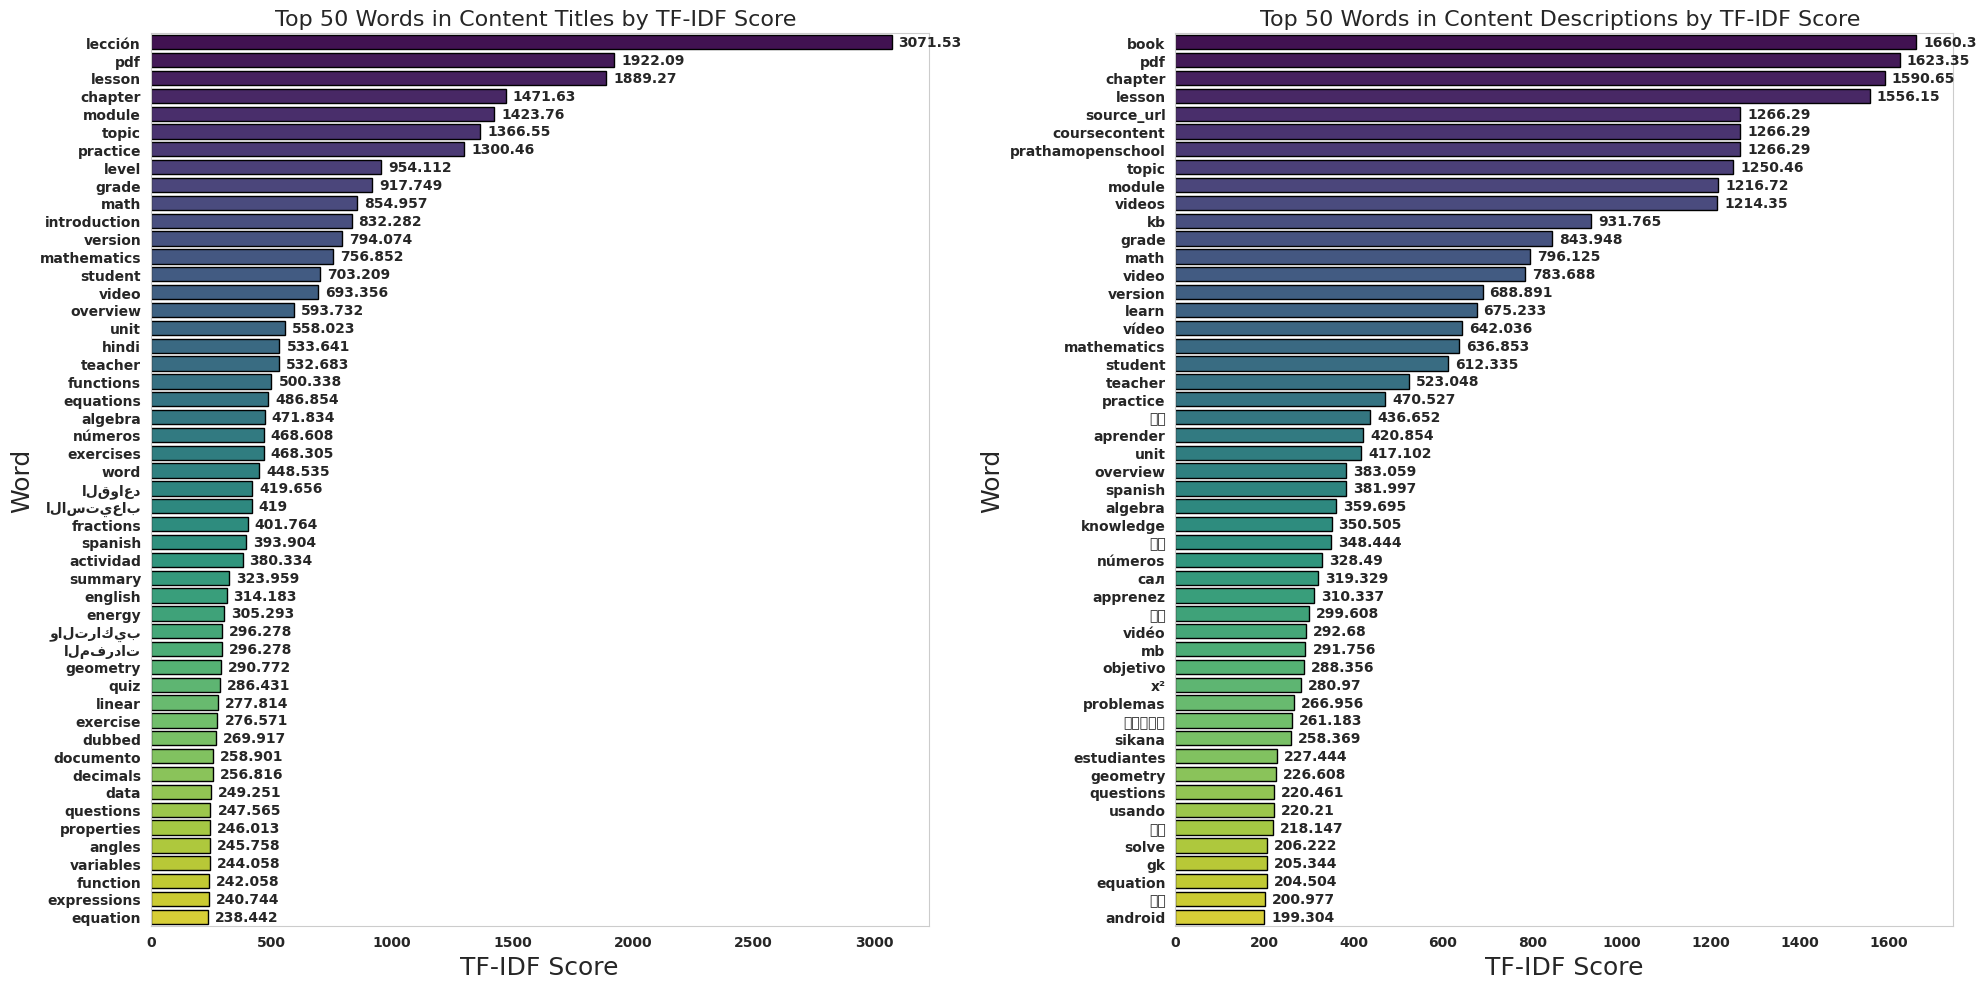

In [24]:
# @title TF-IDF Top 50
# Get the unique languages from the content DataFrame
languages = content['language'].unique().tolist()

# Combine stop words from the languages present in the content DataFrame
combined_stops = set()
for lang in languages:
    try:
        combined_stops.update(stopwords.stopwords(lang))
    except:
        print(f"Could not load stop words for language code: {lang}. Skipping.")


def plot_top_tfidf_words(df, text_column, title, ax, stop_words):
    """
    Generates and displays a bar plot of the top 50 TF-IDF words for a given text column.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str): The name of the column containing the text data.
        title (str): Title for the plot.
        ax (matplotlib.axes.Axes): The axes to plot on.
        stop_words (set): A set of stop words to use.
    """
    # Fill NaN values and convert to string
    text_data = df[text_column].fillna('').astype(str)

    # Remove numbers from the text data
    text_data = text_data.apply(lambda x: re.sub(r'\d+', '', x))

    # Create TF-IDF vectorizer with custom stop words
    tfidf = TfidfVectorizer(stop_words=list(stop_words))

    # Fit and transform the text data
    tfidf_matrix = tfidf.fit_transform(text_data)

    # Get feature names (words)
    feature_names = tfidf.get_feature_names_out()

    # Calculate the sum of TF-IDF scores for each word
    tfidf_sums = np.sum(tfidf_matrix.toarray(), axis=0)

    # Create a pandas Series of words and their total TF-IDF scores
    word_tfidf_scores = pd.Series(tfidf_sums, index=feature_names)

    # Get the top 50 words by TF-IDF score
    top_words = word_tfidf_scores.sort_values(ascending=False).head(50)

    # Create a DataFrame for plotting
    top_words_df = top_words.reset_index()
    top_words_df.columns = ['word', 'tfidf_score']

    # Plot the top 50 words using a bar plot
    sns.barplot(x='tfidf_score', y='word', data=top_words_df, edgecolor="#000000", palette='viridis', ax=ax)

    # Add labels to the bars
    for container in ax.containers:
        ax.bar_label(container, padding=5)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("TF-IDF Score", fontsize=18)
    ax.set_ylabel("Word", fontsize=18)
    ax.grid(axis='x')

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Topic Titles
plot_top_tfidf_words(content, 'title', "Top 50 Words in Content Titles by TF-IDF Score ", axes[0], combined_stops)

# Plot for Topic Descriptions
plot_top_tfidf_words(content, 'description', "Top 50 Words in Content Descriptions by TF-IDF Score ", axes[1], combined_stops)

plt.tight_layout()
plt.show()

#### Language

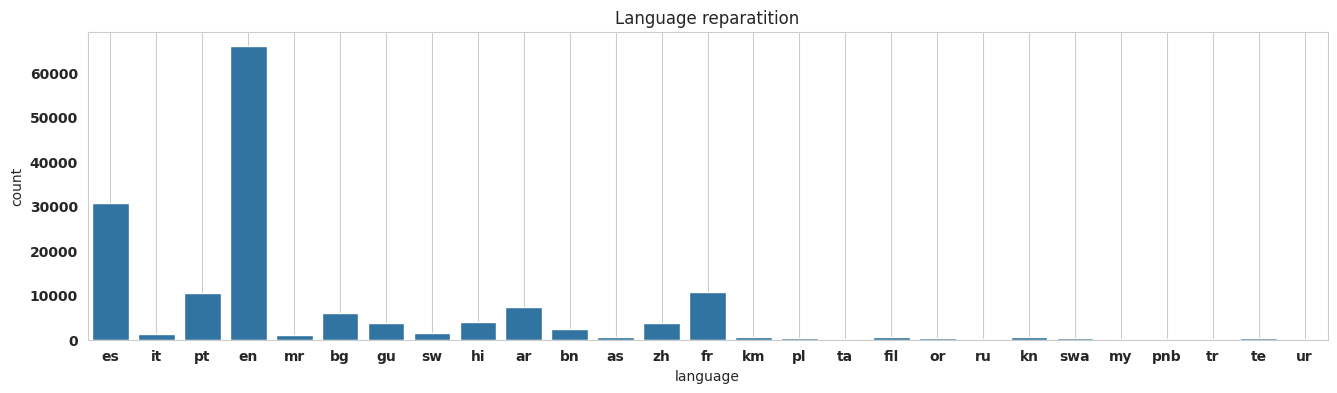

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
sns.countplot(x="language", data=content)
plt.title('Language reparatition')
plt.grid()
plt.show()

#### Kind and Has_content

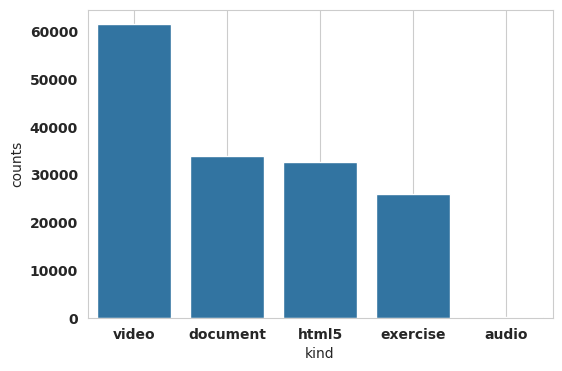

In [26]:
kind_counts = content['kind'].value_counts().rename_axis('kind').reset_index(name='counts')
fig = sns.barplot(kind_counts, x='kind', y='counts')
plt.grid()
plt.show()

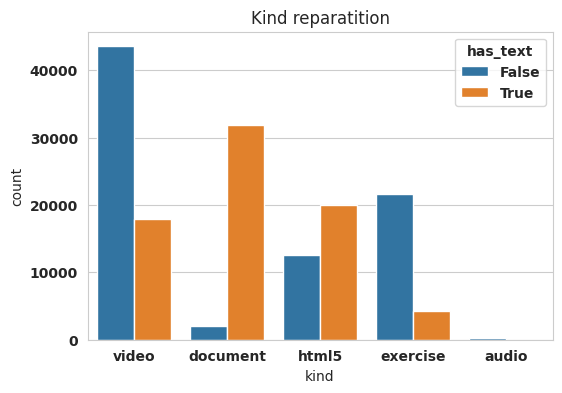

In [27]:
content['has_text'] = ~content['text'].isna()

sns.countplot(x="kind", hue="has_text", data=content)
plt.title('Kind reparatition')
plt.show()

### Correlactions

In [28]:
correlations["content_ids"] = correlations["content_ids"].str.split()

# --- Base Metrics ---
total_topics = topics['id'].nunique()
total_content = content['id'].nunique()

# Generate content <-> topic pairs
topic_content_pairs = []
for _, row in correlations.iterrows():
    for cid in row['content_ids']:
        topic_content_pairs.append((row['topic_id'], cid))

# Create the pair DataFrame
pair_df = pd.DataFrame(topic_content_pairs, columns=['topic_id', 'content_id'])

# Total valid links
total_links = len(pair_df)

# Group by content for statistics
topics_per_content = pair_df.groupby("content_id").agg({"topic_id": "count"}).reset_index()
topics_per_content.columns = ["content_id", "num_topics"]

# Contents with and without topics
num_content_with_topics = topics_per_content['content_id'].nunique()
num_content_without_topics = total_content - num_content_with_topics

# Percentages
pct_with_topics = (num_content_with_topics / total_content) * 100
pct_without_topics = 100 - pct_with_topics

# Descriptive statistics
stats = topics_per_content['num_topics'].describe()

# --- Report ---
print()
print("📊 CONTENT × TOPIC INSIGHT REPORT")
print("========================================")
print(f"🔹 Total unique contents:              {total_content:,}")
print(f"🔹 Total unique topics:                {total_topics:,}")
print(f"🔹 Total content-topic links:          {total_links:,}")

print()
print(f"🔹 Contents with at least 1 topic:     {num_content_with_topics:,} ({pct_with_topics:.2f}%)")
print(f"🔹 Contents with no topics:            {num_content_without_topics:,} ({pct_without_topics:.2f}%)")

print()
print("📈 Number of topics per content statistics:")
print("   ----------------------------------------")
print(f"   - Mean:           {stats['mean']:.2f}")
print(f"   - Median:         {stats['50%']}")
print(f"   - Minimum:        {stats['min']}")
print(f"   - Maximum:        {stats['max']}")
print(f"   - Std deviation:  {stats['std']:.2f}")
print(f"   - 25th percentile:{stats['25%']}")
print(f"   - 75th percentile:{stats['75%']}")


📊 CONTENT × TOPIC INSIGHT REPORT
🔹 Total unique contents:              154,047
🔹 Total unique topics:                76,972
🔹 Total content-topic links:          279,919

🔹 Contents with at least 1 topic:     154,047 (100.00%)
🔹 Contents with no topics:            0 (0.00%)

📈 Number of topics per content statistics:
   ----------------------------------------
   - Mean:           1.82
   - Median:         1.0
   - Minimum:        1.0
   - Maximum:        241.0
   - Std deviation:  2.00
   - 25th percentile:1.0
   - 75th percentile:2.0


### Conclusion

### EDA Conclusion

Based on the exploratory data analysis of the `topics`, `content`, and `correlations` dataframes, the following observations were made:

**Topics Dataframe:**
- The `topics` dataframe contains information about educational topics, including titles, descriptions, channels, categories, levels, languages, parents, and whether they have associated content.
- There are missing values in the `description` column, indicating that not all topics have a description.
- The majority of topics are in English, followed by Spanish and Portuguese.
- The distribution of word counts in topic titles and descriptions is highly right-skewed, with most titles and descriptions being short.
- The TF-IDF analysis revealed the most important words in topic titles and descriptions after removing stop words and numbers.
- Applying Zipf's Law helped identify the most frequent words that cover 90% of the total word usage, which can be used to limit the vocabulary for further analysis.

**Content Dataframe:**
- The `content` dataframe contains information about educational content, including titles, descriptions, kinds, texts, languages, copyright holders, and licenses.
- There are missing values in the `description`, `text`, `copyright_holder`, and `license` columns. The `text` column has the highest percentage of missing values.
- Similar to topics, the majority of content is in English, followed by Spanish and Portuguese.
- The distribution of word counts in content titles, descriptions, and text is also right-skewed, with most content having short titles and descriptions, but some having longer text.
- The TF-IDF analysis for content titles and descriptions showed important words related to the content.


**Content & Topic TF-IDF**
We observe a clear intersection of key educational terms in both topic titles and descriptions, such as "equations", "functions", "module", "topic", "lesson", "student", "teacher", "math", "videos", and "números". These recurring words suggest that the content is heavily focused on foundational math concepts and instructional formats. The consistency across both titles and descriptions highlights a coherent thematic structure, where instructional materials (videos, modules) are closely tied to math-related learning objectives (e.g., algebra, fractions, equations).

**Correlations Dataframe:**
- The `correlations` dataframe links topics to content.
- All unique content items are linked to at least one topic.
- The average number of topics per content is around 1.82, with a median of 1. This suggests that most content is linked to a small number of topics, but some content is linked to a large number of topics (maximum of 241).

Overall, the EDA provides a good understanding of the characteristics of the topics and content data, as well as the relationships between them. This information will be valuable for subsequent steps such as feature engineering and model building for content recommendation.


